<a href="https://colab.research.google.com/github/kiyaoiki/Credit-Card-Fraud-Detection/blob/main/Credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kagglehub

In [3]:
import kagglehub

In [4]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud


In [5]:
import os
os.listdir(path)

['creditcard.csv']

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

from imblearn.over_sampling import BorderlineSMOTE
from xgboost import XGBClassifier

In [7]:
csv_path = os.path.join(path, "creditcard.csv")
df = pd.read_csv(csv_path)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.shape

(284807, 31)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [11]:
df['Class'].value_counts()

,count
Class,
0,284315
1,492


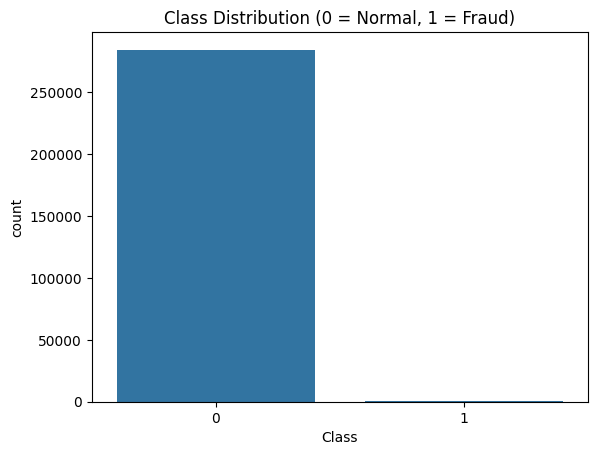

In [12]:
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0 = Normal, 1 = Fraud)")
plt.show()

In [13]:
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,      # VERY important for imbalanced data
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (227845, 30)
Test shape : (56962, 30)


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Scaling completed")

Scaling completed


In [16]:
from imblearn.over_sampling import BorderlineSMOTE

smote = BorderlineSMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train,
    y_train
)

print("After SMOTE:")
print(pd.Series(y_train_smote).value_counts())

After SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


In [17]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

print("XGBoost model created")

XGBoost model created


In [18]:
xgb_model.fit(X_train_smote, y_train_smote)

print("Model training completed")

Model training completed


In [21]:
# Class predictions
y_pred = xgb_model.predict(X_test)

# Probability predictions (needed for ROC-AUC)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Predictions completed")

Predictions completed


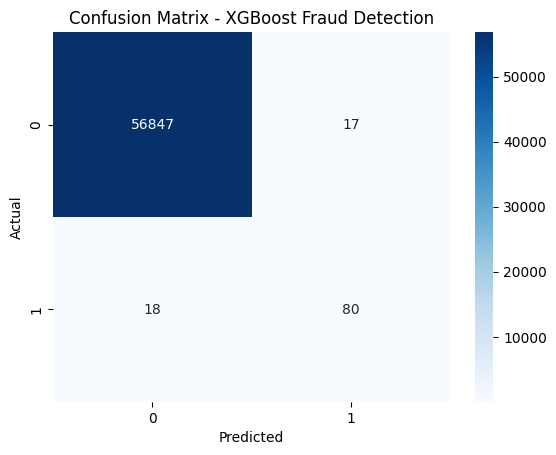

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost Fraud Detection")
plt.show()

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.82      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [24]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9686484329240981


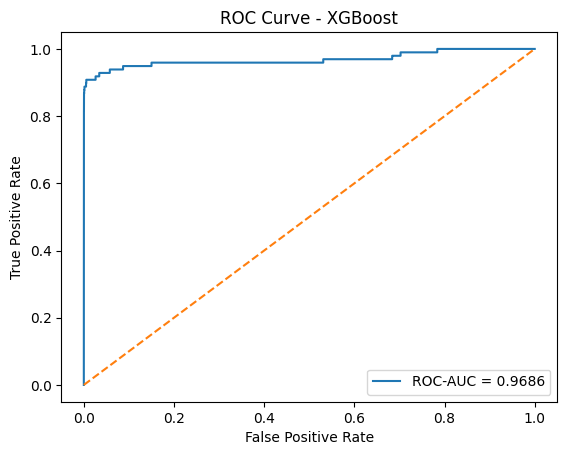

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

In [26]:
# Custom threshold
threshold = 0.3

y_pred_custom = (y_prob >= threshold).astype(int)

from sklearn.metrics import confusion_matrix, classification_report

cm_custom = confusion_matrix(y_test, y_pred_custom)
print("Confusion Matrix (Threshold = 0.3):")
print(cm_custom)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom))

Confusion Matrix (Threshold = 0.3):
[[56841    23]
 [   15    83]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.85      0.81        98

    accuracy                           1.00     56962
   macro avg       0.89      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [27]:
!pip install shap

In [28]:
import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

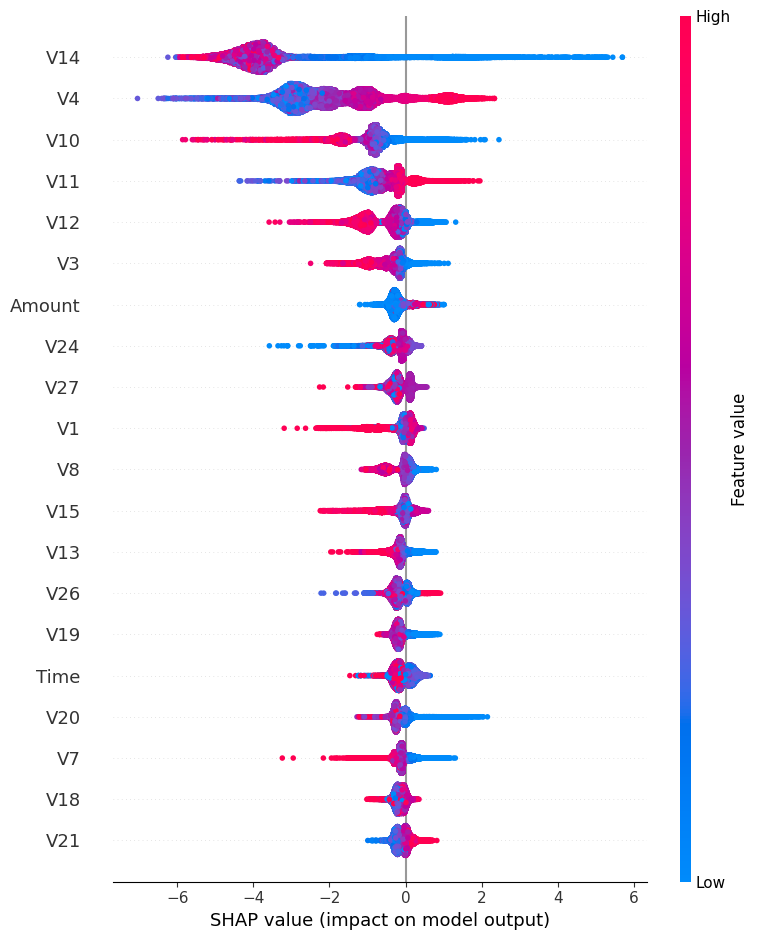

In [29]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [30]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=200,
    contamination=0.0017,  # fraud ratio
    random_state=42
)

iso.fit(X_train)

IsolationForest(contamination=0.0017, n_estimators=200, random_state=42)

In [31]:
iso_pred = iso.predict(X_test)

# Convert (-1 = anomaly) → 1 = fraud
iso_pred = np.where(iso_pred == -1, 1, 0)

print(confusion_matrix(y_test, iso_pred))
print(classification_report(y_test, iso_pred))

[[56791    73]
 [   68    30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.29      0.31      0.30        98

    accuracy                           1.00     56962
   macro avg       0.65      0.65      0.65     56962
weighted avg       1.00      1.00      1.00     56962



In [33]:
importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

importance.head(10)

,Feature,Importance
14,V14,0.610344
4,V4,0.144973
11,V11,0.044007
17,V17,0.037287
10,V10,0.029987
3,V3,0.027331
27,V27,0.011207
1,V1,0.011074
12,V12,0.009599
16,V16,0.006520


In [34]:
import joblib

joblib.dump(xgb_model, "fraud_xgboost_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved")

Model and scaler saved
